# Signal processing

This notebook will demonstrate some signal processing methods for determining range with an active remote sensing system. The next block of code can make and plot different pulse shapes. Select and run to define the functions.

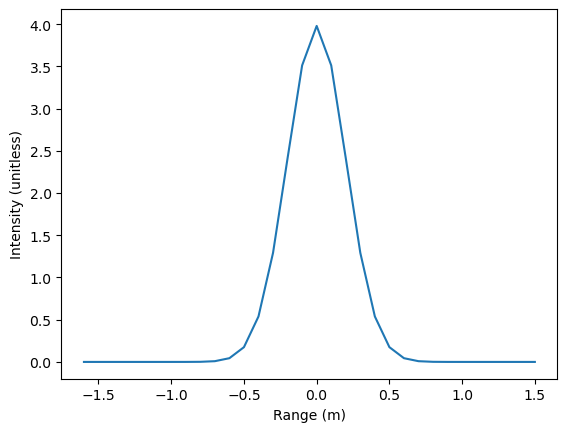

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi,sqrt
from scipy.signal import convolve



class setPulse():
    '''Class to hold and manipulate pulses'''
    
    def __init__(self,sigma,mode,res=0.1,E=1,sFreq=100000,eFreq=1000000000):
        '''Initialiser'''
        
        # save pulse properties within object
        self.sigma=sigma
        self.E=E
        self.res=res
        self.sFreq=sFreq
        self.eFreq=eFreq
        
        # behaviour depends upon pulse
        if(mode=="gauss"):
            self.A=self.E/(sigma*sqrt(2*pi))
            self.pX=np.arange(-sigma*8,sigma*8,res)
            self.pY=self.A*np.exp(-1*self.pX**2/(2*sigma**2))/(sigma*sqrt(2*pi))
        elif(mode=="chirp"):
            self.makeChirp()
        else:
            print(mode,"pulse shape mode not recognised.")
            print("mode must be gauss or chirp")

        return
            
    def makeChirp(self):
        '''Make a chirped pulse. Written by J Hansen for GLAMIS project'''
        self.pX = np.arange(0, self.sigma, self.res)
        t = self.pX / 2.998e8
        
        stime = self.sigma / (2.998e8)
        c = (self.eFreq - self.sFreq) / stime  # sweep scaling constant
        self.pY = np.sin(2.0 * pi * (t**2 * (c/2.0) + self.sFreq * t))
        
        # set energy to be correct total
        totE=np.sum(self.pY)*self.res
        self.pY=self.pY*self.E/totE

        return

    def setTarget(self,N,sep):
        '''Make a target profile'''
        self.tY=np.zeros((self.pX.shape),dtype=float)
        centX=np.mean(self.pX)
        for i in range(0,N):
            x=centX+i*sep
            minInd=np.abs(self.pX-x).argmin()
            self.tY[minInd]=1.0
            print(x,minInd,self.pX[minInd])
        return
        
    def xcorr(self):
        '''Compute cross-correlation of pulse and target'''
        N = max(len(self.pY), len(self.tY))
        X = np.fft.fft(self.pY, n=N)
        Y = np.fft.fft(self.pY, n=N)
        z = np.real(np.fft.ifft(X * np.conj(Y)))
        self.correl = z*(np.sum(self.pY) + np.sum(self.tY)) / (np.sum(self.pY) * np.sum(self.tY))
        return
    
    def convolve(self):
        """Compute convolution of target and pulse"""
        #N = max(self.pY.shape[0],self.tY.shape[0])
        #X = np.fft.fft(self.pY, n=N)
        #Y = np.fft.fft(self.tY, n=N)
        #self.conv = np.real(np.fft.ifft(X * Y))
        self.conv=convolve(self.pY,self.tY,mode='full')
        sX=self.pX[0]-(np.mean(self.pX)/2.0-self.pX[0])
        eX=sX+self.res*self.conv.shape[0]
        self.cX=np.linspace(sX,eX,num=self.conv.shape[0])
        return
        
    def plotPulse(self):
        '''Plot the pulse'''
        plt.xlabel('Range (m)')
        plt.ylabel('Intensity (unitless)')
        plt.plot(self.pX,self.pY-np.min(self.pY))
        plt.show()
        
    def plotConv(self):
        '''Plot the target and convolution'''
        plt.xlabel('Range (m)')
        plt.ylabel('Intensity (unitless)')
        plt.plot(self.pX,self.tY-np.min(self.tY),label="Target")
        plt.plot(self.cX,self.conv-np.min(self.conv),label="Convolution")
        plt.show()

        
        
########################
# Set and plot a pulse

mode="gauss"    # the type of pulse. "gauss" or "chirp"
sigma=0.2       # 1 m width
E=1.0           # amount of energy in pulse

pulse=setPulse(sigma,mode)
pulse.plotPulse()


## Changing the pulse shape

Have a go at making differtent pulse shapes by changing "mode", "sigma", "sFreq" and "eFreq" in the code block below. Try keeping the mode as "gauss" and answer the following.

1. What happens when you increase "sigma" for a Gaussian pulse?
2. What happens to the peak intensity when you decrease sigma for a Gaussian pulse?
3. What happens when you make sigma less than 0.2?

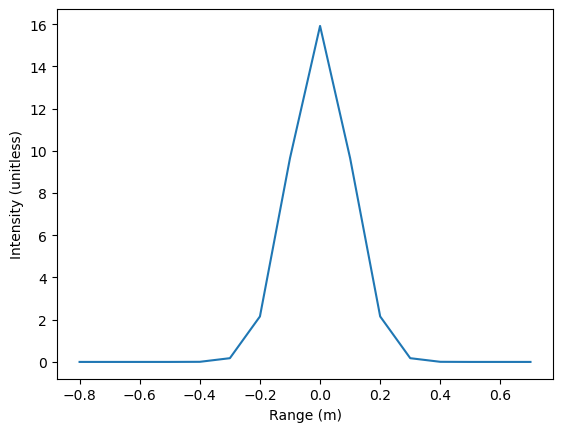

In [37]:
# pulse properties
mode="gauss"    # the type of pulse. "gauss" or "chirp"
sigma=0.1       # 1 m width


# set and plot a pulse with the properties from above
pulse=setPulse(sigma,mode)
pulse.plotPulse()


## Pulse shape accuracy

You should notice that the pulse gets less smooth if the width is narrowed. This is because by default the pulse is sampled every 10 cm, leading to a poor representation of the shape. This can cause issues when pattern matching, especially for complex pulse shapes.

Change the mode to "chirp" and repeat the questions.

1. Plot a chirp
2. For the same total energy, how does the peak intensity compare to a Gaussian pulse?
3. The high-frequency part of the pulse contains "aliasing". Try and remove this by adjusting the resolution. What resolution removes the aliasing?
4. What happens if you change the end frequency "eFreq"?

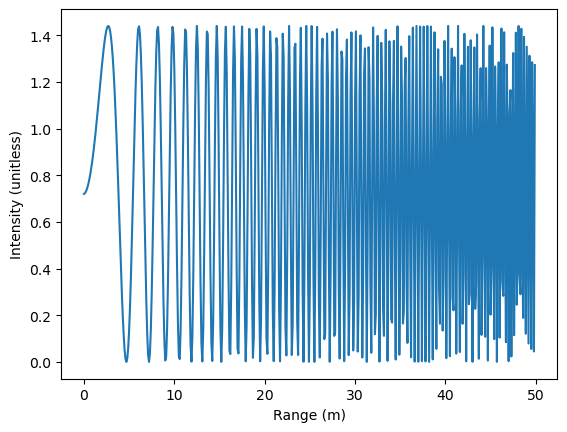

In [41]:
# pulse properties
mode="chirp"   # the type of pulse. "gauss" or "chirp"
sigma=50       # 50 m width
E=1.           # total energy in the pulse
res=0.1        # 10 cm resolution
sFreq=10**6    # chirp start frequency. 1 MHz
eFreq=10**9    # chirp end frequency. 1 GHz


# set and plot a pulse with the properties from above
pulse=setPulse(sigma,mode,res=res,E=E,sFreq=sFreq,eFreq=eFreq)
pulse.plotPulse()


## Sampling a pulse

A rule of thumb for recognising shapes is that they need to be sampled at twice the frequency as the highest frequency within the shape. For a chirp this is twice the frequency of the end frequency. For a Gaussian it is a little more complicated as the effecgive frequency of the shape changes across it, but for now only worry about it for chirps.

## Pulses interacting with a target

When a pulse is emitted from an active remote sensing instrument that pulse will reflect from every part of the target. This can be represented by "convolving" the target profile (graph of reflections with range) with the pulse shape to give the returned energy profile. The code below will create a target profile with "N" scattering objects separated by "sep" metres and then plot the convolution of that with the pulse.

-0.050000000000028424 79 -0.10000000000002807


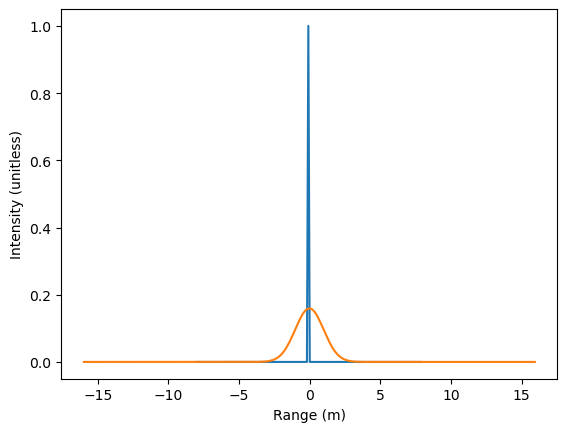

In [8]:
# pulse properties
mode="gauss"   # the type of pulse. "gauss" or "chirp"
sigma=1        # 1 m width
E=1.           # total energy in the pulse
res=0.1        # 10 cm resolution
sFreq=10**6    # chirp start frequency. 1 MHz
eFreq=10**9    # chirp end frequency. 1 GHz

# target properties
N=1       # scattering object
sep=1.0   # 1 m between scattering objects if N>1


# set pulse and target propertries
pulse=setPulse(sigma,mode,res=res,E=E,sFreq=sFreq,eFreq=eFreq)
pulse.setTarget(N,sep)

# convolve
pulse.convolve()

# plot it
pulse.plotConv()
